In [1]:
audio_path = "audio-data/collins.mp3"
name = "collins-overlap"

# segmentation
block_length = 1 # number of frames in a stream block
frame_beats = 1/2 # frame size in beats
hop_beats = 1/4 # hop length in beats
detect_BPM = False
BPM = 108
## alternatively, you can specify frame length and hop length in seconds
# frame_length_s = 0.1
# hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# feature extraction
extract_mfccs = False

# clustering
n_classes = 32
maxlen = 16

# model architecture and training
step = 1 # step size for sliding window
hidden_units = 64 # number of hidden units in GRU layer
epochs = 100
batch_size = 32
validation_split = 0.2
early_stopping = True
checkpoint = True
patience = 5 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [2]:
def beats_to_samples(beats, bpm, sr):
    beats_per_second = bpm / 60.0
    samples_per_beat = sr / beats_per_second
    total_samples = int(samples_per_beat * beats)
    return total_samples

In [3]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import matplotlib.ticker as mticker
import librosa.display
from IPython.display import Audio, display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy
from keras.utils import to_categorical
from keras import Sequential
import pickle

sr = librosa.get_samplerate(audio_path)
if BPM is not None and frame_beats is not None:
    frame_length = beats_to_samples(frame_beats, BPM, sr)
    frame_length_s = frame_length / sr
if BPM is not None and hop_beats is not None:
    hop_length = beats_to_samples(hop_beats, BPM, sr)
    hop_length_s = hop_length / sr
stream = Streamer(audio_path, block_length, frame_length, hop_length)
path = Path(directory + "/models/" + name)
path.mkdir(exist_ok=True, parents=True)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

def plot_waveform_and_spectrogram(audio, divisions, bpm, sr, plot_duration, plot_offset):
    # Calculate frame size in samples
    frame_size = beats_to_samples(divisions, bpm, sr)
    
    # Calculate the number of frames
    num_frames = len(audio) // frame_size
    
    # Calculate the number of samples to plot
    plot_offset = int(plot_offset * sr)
    samples_to_plot = int(plot_duration * sr)
    
    # Truncate the audio to the desired duration
    audio = audio[plot_offset:plot_offset+samples_to_plot]
    
    # Create a time axis for the waveform plot
    t = np.arange(len(audio)) / sr
    
    # Plot the waveform
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    
    # Visualize divisions using red vertical lines
    for i in range(num_frames):
        frame_start = i * frame_size
        frame_end = (i + 1) * frame_size
        if frame_start < samples_to_plot:
            plt.vlines(frame_start / sr, np.min(audio), np.max(audio), colors='red', alpha=0.5)
            plt.vlines(frame_end / sr, np.min(audio), np.max(audio), colors='red', alpha=0.5)
    
    # Create a spectrogram
    f, t, Sxx = signal.spectrogram(audio, sr)
    
    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='inferno')
    plt.colorbar(label='Power Spectral Density (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    
    # Visualize divisions using red vertical lines
    for i in range(num_frames):
        frame_start = i * frame_size
        frame_end = (i + 1) * frame_size
        if frame_start < samples_to_plot:
            plt.vlines(frame_start / sr, 0, np.max(f), colors='cyan', alpha=0.8)
            plt.vlines(frame_end / sr, 0, np.max(f), colors='cyan', alpha=0.8)
    
    plt.tight_layout()
    plt.show()


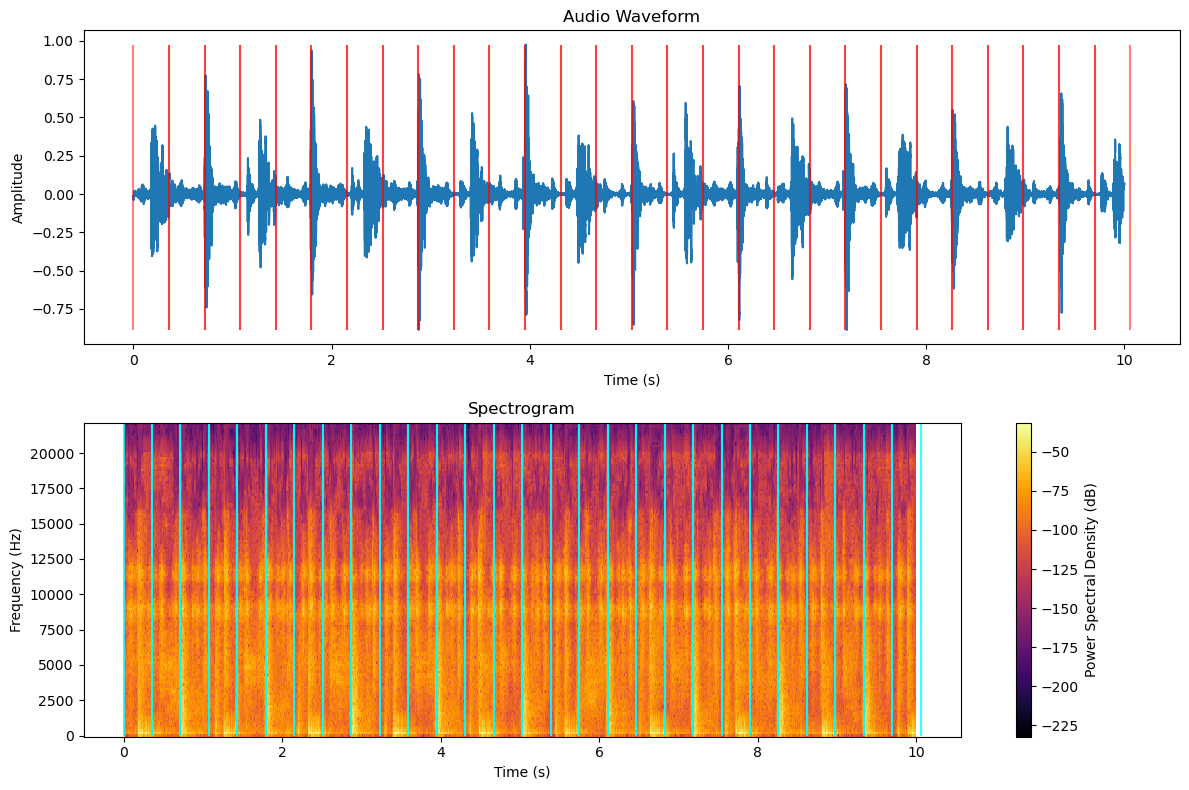

In [5]:
y, sr = librosa.load(audio_path, sr=sr)
plot_waveform_and_spectrogram(y, 1, 167, sr, 10, 60)

In [6]:
# helper function to extract features from audio block
def extract_features(y, sr, extract_mfccs=False):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=hop_length, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    m_centroid = np.median(spectral_centroid, axis=1)
    m_bandwith = np.median(spectral_bandwith, axis=1)
    m_flatness = np.median(spectral_flatness, axis=1)
    m_rolloff = np.median(spectral_rolloff, axis=1)
    if extract_mfccs:        
        if y.size >= 2048:  
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False, n_fft=hop_length, hop_length=hop_length) # mfccs
        else:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
        m_mfccs = np.median(mfccs[:], axis=1)
    features = np.array([])
    features = np.concatenate((
        features,
        m_centroid,
        m_bandwith,
        m_flatness,
        m_rolloff
    ))
    if extract_mfccs:
        features = np.concatenate((
            features,
            m_mfccs
        ))
    if len(features) == 0:
        return None
    return features

Audio length: 200.46473922902496s, 8840495 samples
Sample rate: 44100 Hz
Frame length: 0.2777777777777778s,  12250 samples
Hop length: 0.1388888888888889s, 6125 samples
Block length: 1 frame(s)
Number of blocks: 1444
(1443, 4)
(1443, 4)
[-1. -1. -1. -1.]
[1. 1. 1. 1.]
[ 0.32169512  0.49735838 -0.85945732  0.49310841]


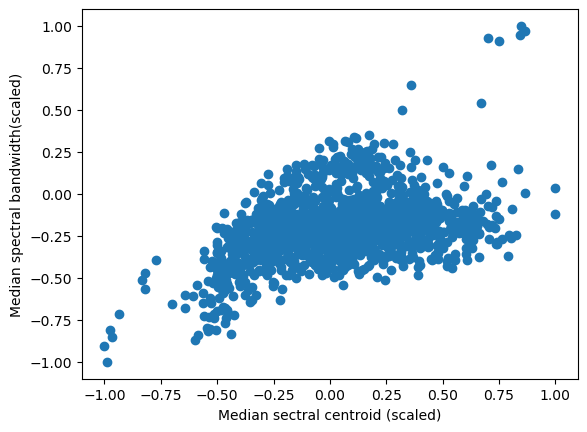

In [7]:
print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr, extract_mfccs=extract_mfccs) for block in stream.new()])
# features_scaled = features
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
# features_scaled = preprocessing.scale(features, axis=0) # should it be axis 0 then not 1??
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    plt.xlabel('Median sectral centroid (scaled)')
    plt.ylabel('Median spectral bandwidth(scaled)')
    plt.show()
    # plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    # plt.show()

In [8]:
# cluster features
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)
labels[:4]

array([8, 3, 3, 3], dtype=int32)

/var/folders/kt/3yzrdbd548lfc1w4yd4phlwm0000gn/T/ipykernel_25826/1695150304.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_classes)


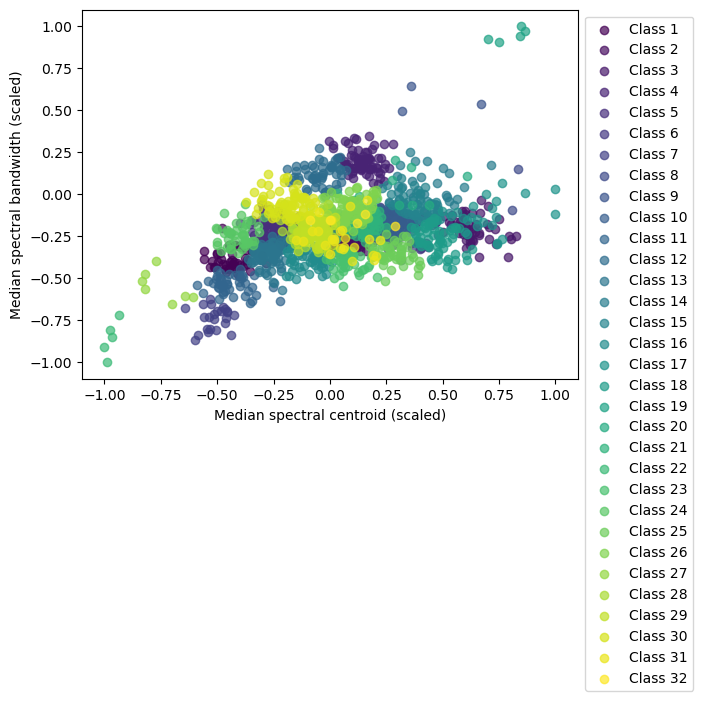

In [9]:
# Define a color map for the clusters
cmap = plt.cm.get_cmap('viridis', n_classes)

# Plot the data points with colors corresponding to their labels and add labels to legend
for i in range(n_classes):
    plt.scatter(features_scaled[labels==i, 0], features_scaled[labels==i, 1], color=cmap(i), alpha=0.7, label='Class {}'.format(i+1))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Median spectral centroid (scaled)')
plt.ylabel('Median spectral bandwidth (scaled)')
plt.savefig(path / (name + "_clusters.png"), bbox_inches='tight')
plt.show()

In [10]:
n_labels = len(np.unique(labels))
labels = labels.tolist()
# save labelled sequence of frames
labels_path = path / (name + "_labels.csv")
np.savetxt(labels_path, (labels), fmt='%s,')
if verbose:
    print(f"Total labelled frames: {len(labels)}")
    print(f"n_labels: {n_labels} (sanity check)")
    print("Labelled frame sequence saved to: " + str(labels_path))

Total labelled frames: 1443
n_labels: 32 (sanity check)
Labelled frame sequence saved to: models/collins-overlap/collins-overlap_labels.csv


In [11]:

frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
# frames # sanity check

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

# build a subsequence for every <step> frames
# and a corresponding label that follows it
x = [] # these will be features
y = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    x.append(labels[i: i + maxlen])
    y.append(labels[i + maxlen])
# x_ = np.array(features)
# y_ = np.array(targets)
# one-hot encode features and targets
x_ = to_categorical(x, dtype ="bool")
y_ = to_categorical(y, dtype ="bool")
# sanity check
if verbose:
    print(x_.shape)
    print(y_.shape)

90
55125 67375
(1427, 16, 32)
(1427, 32)


In [12]:
# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py
model_path = path / (name + ".keras")
inputs = Input(shape=(maxlen, n_labels), name='input_layer')
x = GRU(hidden_units, name='gru_layer')(inputs)
outputs = Dense(n_labels, activation='softmax', name='output_layer')(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
callbacks = []
if early_stopping:
    callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=patience
    ))
if checkpoint:
    callbacks.append(ModelCheckpoint(
        filepath=model_path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ))
model.compile(
    loss='categorical_crossentropy', # since we are using one-hot encoded labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()


history = model.fit(
    x_,
    y_,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=0.2,
    callbacks=callbacks
)

Metal device set to: Apple M1
Model: "collins-overlap"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16, 32)]          0         
                                                                 
 gru_layer (GRU)             (None, 64)                18816     
                                                                 
 output_layer (Dense)        (None, 32)                2080      
                                                                 
Total params: 20,896
Trainable params: 20,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-28 16:24:24.406928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36/36 [==============================] - 8s 60ms/step - loss: 3.4472 - accuracy: 0.0447 - val_loss: 3.4045 - val_accuracy: 0.1049
Epoch 2/100
36/36 [==============================] - 1s 19ms/step - loss: 3.3559 - accuracy: 0.1218 - val_loss: 3.3296 - val_accuracy: 0.0944
Epoch 3/100
36/36 [==============================] - 1s 19ms/step - loss: 3.2488 - accuracy: 0.1218 - val_loss: 3.2541 - val_accuracy: 0.0909
Epoch 4/100
36/36 [==============================] - 1s 20ms/step - loss: 3.1486 - accuracy: 0.1332 - val_loss: 3.2107 - val_accuracy: 0.0839
Epoch 5/100
36/36 [==============================] - 1s 19ms/step - loss: 3.0644 - accuracy: 0.1543 - val_loss: 3.1867 - val_accuracy: 0.0874
Epoch 6/100
36/36 [==============================] - 1s 19ms/step - loss: 2.9922 - accuracy: 0.1674 - val_loss: 3.1583 - val_accuracy: 0.0979
Epoch 7/100
36/36 [==============================] - 1s 19ms/step - loss: 2.9261 - accuracy: 0.1753 - val_loss: 3.1417 - val_accuracy: 0.0979
Epoch 8/100
36/36 

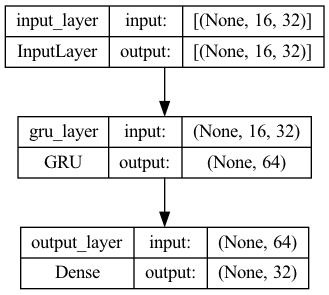

In [13]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [14]:
print(f"Saved model to: {path}")
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["frame_beats"] = frame_beats
config["hop_beats"] = hop_beats
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")

Saved model to: models/collins-overlap
Saved model to: models/collins-overlap/collins-overlap.keras
Saved frames to: models/collins-overlap/collins-overlap_frames.json
Saved config to: models/collins-overlap/collins-overlap_config.json


In [15]:
history = history.history
h_path = path / (name + "_history")
with open(h_path, 'wb') as file_pi:
    pickle.dump(history, file_pi)
if verbose:
    print(f"Saved history to: {h_path}")

Saved history to: models/collins-overlap/collins-overlap_history


In [16]:
with open(h_path, "rb") as file_pi:
    history = pickle.load(file_pi)

In [17]:
print(f"Total epochs : {len(history['loss'])}")
print("Minimum validation loss: ", min(history['val_loss']), "\nEpoch: ", np.argmin(history['val_loss']))
print("Maximum validation accuracy: ", max(history['val_accuracy']), "\nEpoch: ", np.argmax(history['val_accuracy']))

Total epochs : 50
Minimum validation loss:  2.919297456741333 
Epoch:  44
Maximum validation accuracy:  0.1538461595773697 
Epoch:  38


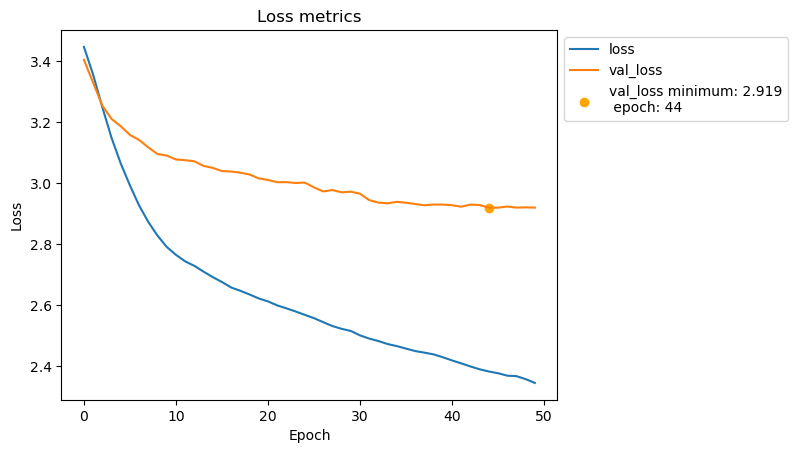

In [18]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
vl_min = min(history['val_loss'])
vl_min_epoch = np.argmin(history['val_loss'])
plt.scatter(vl_min_epoch, vl_min,c='orange', label=f'val_loss minimum: {vl_min:.3f}\n epoch: {vl_min_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Loss metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.tight_layout()
plt.savefig(path / (name + "_loss.png"), bbox_inches='tight')
plt.show()

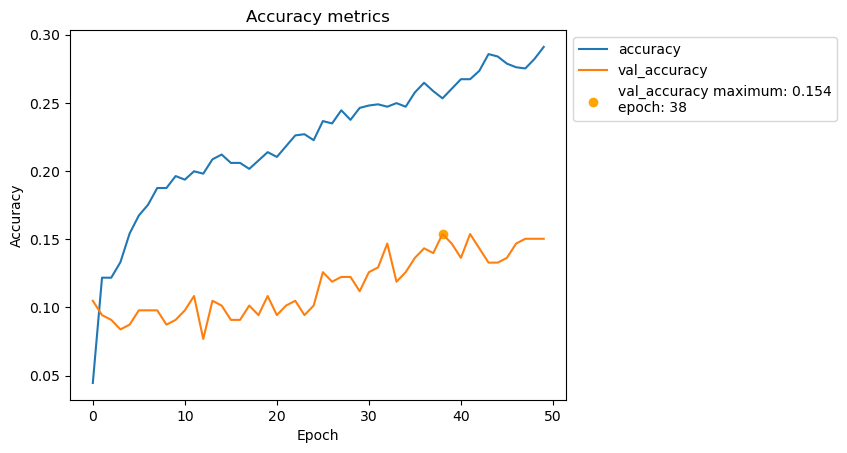

In [19]:
plt.plot(history["accuracy"], label="accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
va_max = max(history['val_accuracy'])
va_max_epoch = np.argmax(history['val_accuracy'])
plt.scatter(va_max_epoch, va_max,c='orange', label=f'val_accuracy maximum: {va_max:.3f}\nepoch: {va_max_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Accuracy metrics")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path / (name + "_accuracy.png"), bbox_inches='tight')
plt.show()

In [20]:
seq = labels[:16]
print("Sequence do detokenise:\n", seq)
out = []
for label in seq:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Sequence do detokenise:
 [8, 3, 3, 3, 3, 3, 3, 3, 3, 0, 21, 21, 21, 26, 21, 21]


In [21]:
# labels[0]

In [22]:
# sr

In [23]:
# out

In [24]:
# cd samps

In [25]:
# import soundfile as sf
# c = 2
# # out = np.array([])
# for i, ind in enumerate(labelled_frames[c]):
#     if i % 2:
#         start = labelled_frames[c][i-1]
#         end = labelled_frames[c][i]
#         # print(start,end)
#         frame = np.array(y[start:end])
#         # print(frame)
#         # out = np.concatenate((out, frame))
#         # print(out)
#         display(Audio(frame, rate=sr))
#         ind = int(i / 2)
#         sampname = f"class_{c}_{ind}.wav" 
#         sf.write(sampname, frame, sr)

In [26]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [27]:
def generate(prompt=[], length=4, temperature=-1, include_prompt=False, verbose=0):
    # print("Read prompt: ", prompt)
    # generate a sequence of given length       
    if len(prompt) == 0:
        # if it's there's no prompt, use an array of zeroes
        prompt = np.zeros((maxlen), dtype="uint8")
        print(f"No prompt provided, using {maxlen} zeroes instead.")
    elif len(prompt) < maxlen:
        # if prompt is too short, pad it with zeroes from the left to match correct input shape
        prompt = np.pad(prompt, (maxlen - len(prompt), 0), 'constant', constant_values=(0, 0))
        print("Prompt too short, padded to length: ", maxlen)
    elif len(prompt) > maxlen:
        # if it's too long, then trim it
        prompt = prompt[-maxlen:]
        print(f"Prompt too long, using {maxlen} last elements: ")
    prompt_ = to_categorical(prompt, num_classes=n_classes)
    prompt_ = np.array([prompt_])
    
    seq = []
    for i in range(length):
        # make prediction based on prompt
        ps = model.predict(prompt_, verbose=verbose)
        # sample from predictions
        if temperature > 0.01:
            p_label = np.argmax(ps)
        else:
            p_label = sample(ps, temperature)
        # add sampled label to sequence
        seq.extend([int(p_label)])
        # one-hot encode sampled label
        p_label_ = to_categorical(p_label, num_classes=n_classes)
        p_label_ = np.array([[p_label_]])
        # append encoded label to the prompt for next prediction
        prompt_ = np.append(prompt_, p_label_, axis=1)
    if include_prompt:
        prompt = np.append(prompt, seq)
        return prompt
    else:
        return seq

In [28]:
seq_ = generate(seq, length=16, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [16, 10, 31, 8, 18, 10, 21, 1, 7, 18, 31, 18, 21, 1, 7, 15]


In [29]:
seq_ = generate(seq, length=16, temperature=1.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [26, 26, 26, 23, 29, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [30]:
seq_ = generate(seq, length=16, temperature=1.5, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [26, 26, 26, 23, 29, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [31]:
seq_ = generate(seq, length=16, temperature=2.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [26, 26, 26, 23, 29, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [32]:
seq_ = generate(seq, length=16, temperature=40.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [26, 26, 26, 23, 29, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
